Data is at ../Gaia_var.fits

Data is retrieved using the ```ellipsoid.py``` script

### Import Packages

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table
from scipy.stats import binned_statistic, binned_statistic_2d

import cubehelix

In [2]:
import matplotlib
from mpl_toolkits.mplot3d import axes3d   
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

#### Color Maps

In [3]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

#### Create SkyCoord Object for SN1054 with RA, Dec, Distance

In [4]:
# Properties of SN1054 (Crab Nebula)
t0 = Time({'year': 1054, 'month': 7, 'day': 4}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1054')

# https://vizier.cds.unistra.fr/viz-bin/VizieR-4 database (photogeometric distance)
d0 = 1899.33655000 * u.pc
d0_err = (2193.16919000-1711.93213000)/2 * u.pc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  ErfaWarning)


In [5]:
c0

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (83.63311446, 22.01448714, 1899.33655)>

In [6]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63311446, 22.01448714)>
1899.33655 pc


#### Read in Gaia Data and Turn Into SkyCoord Objects

In [7]:
Gaia_file = '../../Gaia_var_class.fits'
Gaia = Table.read(Gaia_file, format='fits')

In [8]:
c1 = SkyCoord(ra = Gaia['ra'],
              dec = Gaia['dec'],
              distance = Gaia['dist'],
              frame = 'icrs')
# in degrees, degrees, kpc

In [9]:
c1

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(227.93867507, -50.01617692,       nan),
     (227.99462614, -49.99488697, 3102.9685),
     (227.99211899, -49.96739197, 5778.2246), ...,
     (258.54929618, -39.05668939, 2877.4197),
     (258.50467742, -39.04751153, 4067.039 ),
     (258.53483715, -39.0431609 , 5601.7207)]>

In [10]:
c1[0]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (227.93867507, -50.01617692, nan)>

In [11]:
len(Gaia)

9322432

#### Time Since Event Was Observed

In [12]:
t1 = Time.now()
dt = t1-t0

dt.to('year')

/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)


<Quantity 968.05015256 yr>

#### Ellipsoid Geometry

In [13]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center (half the distance from Earth to SN1054, the two foci)
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # semi-major axis of ellipse
# first term is the distance along the major axis beyond Earth -- it is half the distance light would travel in the time since the event was observed
     
print(a-c) # should be half the value of dt above, but in lyr

484.0250762777782 lyr


#### Gaia Star Geometric Properties

In [14]:
d1 = (Gaia['dist']) # dist to Gaia stars (in kpc)

d2 = c1.separation_3d(c0) # dist from all Gaia stars to SN 1054

In [15]:
# Q1. Has the star seen SN1054 yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES
# left side is the distance from the star to SN 1054
# right side is the distance from SN 1054 to Earth plus the extra distance light has travelled since it was observed


# Q2. Is it within the SETI Ellipsoid?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES
# left side is distance from SN 1987A to star plus distance from star to Earth
# right side is the major axis (the sum of the two focal point distances for all points on an ellipse/ellipsoid is equal to the major axis length)

# Q3. Is it within some tolerance of being ON the ellipse?
# Either a range of distance of time
tol = 0.1 # lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol
# check if sum of focal point distances minus the major axis diameter is within the interval (-tol, tol)

In [16]:
print('Total number of variable stars (with epoch photometry) in Gaia:', len(d1))
print('Number of variable stars that have seen SN1054:', np.sum(SNYES))
print('Number of variable stars that have not seen SN1054:', np.sum(SNNO))
print('Number of variable stars inside SETI Ellipsoid:', np.sum(EYES))
print('Number of variable stars within ' + str( tol ) + ' lyr of ellipsoid:', np.sum(OYES))

Total number of variable stars (with epoch photometry) in Gaia: 9322432
Number of variable stars that have seen SN1054: 2147076
Number of variable stars that have not seen SN1054: 7175356
Number of variable stars inside SETI Ellipsoid: 562243
Number of variable stars within 0.1 lyr of ellipsoid: 121


In [17]:
print('Fraction of variable stars that have seen SN1054:', np.sum(SNYES) / len(d1))
print('Fraction of variable stars that have not seen SN1054:', np.sum(SNNO) / len(d1))
print('Fraction of variable stars inside SETI Ellipsoid:', np.sum(EYES) / len(d1))

Fraction of variable stars that have seen SN1054: 0.23031286256633463
Fraction of variable stars that have not seen SN1054: 0.7696871374336653
Fraction of variable stars inside SETI Ellipsoid: 0.060310764401392256


These are lower fractions to those from Gaia variable stars, which is expected since the range of distances is much larger

## Plotting

Text(0.5, 0, 'Z (pc)')

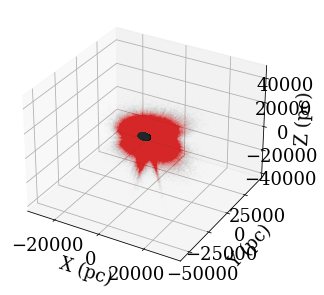

In [20]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Gaia['x'][SNNO], Gaia['y'][SNNO], Gaia['z'][SNNO], c='C3', s=1, alpha=0.005, rasterized=True)
ax.scatter(Gaia['x'][SNYES], Gaia['y'][SNYES], Gaia['z'][SNYES], c='C0', s=1, alpha=0.05, rasterized=True)
ax.scatter(Gaia['x'][EYES], Gaia['y'][EYES], Gaia['z'][EYES], c='C6', s=4, alpha=0.1, rasterized=True)
ax.scatter(Gaia['x'][OYES], Gaia['y'][OYES], Gaia['z'][OYES], c='k', s=20, alpha=0.95, rasterized=True)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

In [18]:
xcoord = c0.transform_to('galactocentric').x.to('pc') + 8122*u.pc
ycoord = c0.transform_to('galactocentric').y.to('pc')
zcoord = c0.transform_to('galactocentric').z.to('pc') - 20.8*u.pc

Text(0.5, 1.0, 'SN 1054 SETI Ellipsoid')

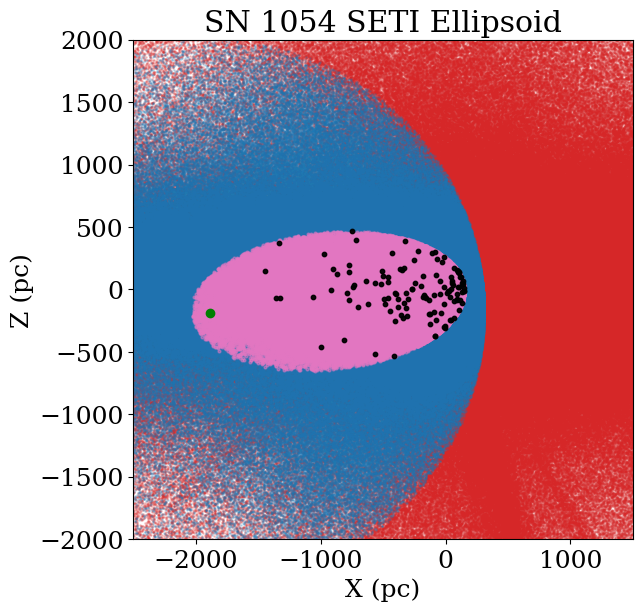

In [24]:
fig = plt.figure(dpi=100,figsize=(8,6), constrained_layout=True)
ax.remove()
ax = fig.add_subplot()

ax.set_aspect('equal', adjustable='box')

ax.scatter(Gaia['x'][SNNO], Gaia['z'][SNNO], c='C3', s=1, alpha=0.2, rasterized=True)
ax.scatter(Gaia['x'][SNYES], Gaia['z'][SNYES], c='C0', s=1, alpha=0.2, rasterized=True)
ax.scatter(Gaia['x'][EYES], Gaia['z'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
ax.scatter(Gaia['x'][OYES], Gaia['z'][OYES], c='k', s=10, alpha=0.95, rasterized=True)
ax.scatter(xcoord, zcoord, c='green')
ax.set_xlabel('X (pc)')
ax.set_ylabel('Z (pc)')
ax.set_xlim(-2500, 1500)
ax.set_ylim(-2000, 2000)
ax.set_title('SN 1054 SETI Ellipsoid')

## Another way of looking at it in terms of time

In [24]:
# The ellipsoid is d2 + r = 2c + time (focal point distances equals major axis)
# So we can rewrite this as time = d2 + r - 2c

etime = d2.to('lyr') + d1.to('lyr') - (2*c)

y10 = (np.abs(Gaia['y']) < 50) & (np.abs(Gaia['x']) < 1500) & (np.abs(Gaia['z']) < 1500) # 'slice' through Gaia, with galactocentric |X| < 10 pc

In [25]:
np.ma.sum(y10)

173518

/mnt_home/anilipour/setiellipsoid/setienv/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  ErfaWarning)


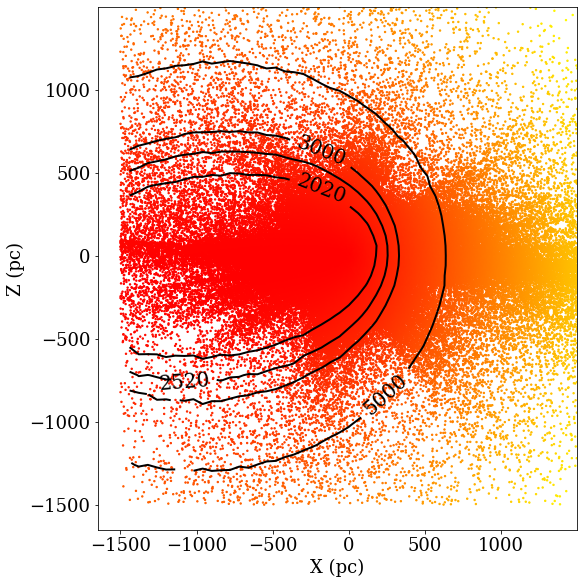

In [26]:
H, xe, ye, bn = binned_statistic_2d(Gaia['x'][y10], Gaia['z'][y10],
                                    values = etime[y10].value + t0.decimalyear, 
                                    statistic='mean', bins=50) # mean binning for contours
XX, YY = np.meshgrid(xe, ye)


plt.figure(figsize=(8,8), constrained_layout=True)
plt.scatter(Gaia['x'][y10], Gaia['z'][y10],
            c=(etime[y10].value + t0.decimalyear), cmap=plt.cm.autumn, rasterized=True, s=2)


# contour is the time (d2 + r - 2c) plus the time when the event was observed on Earth (1987)

cs = plt.contour(xe[1:], ye[1:], H.T, colors='k', linewidths=2, levels=[2020, 2520, 3000, 5000]) # binned contours
plt.clabel(cs, fontsize=20)



plt.xlabel('X (pc)')
plt.ylabel('Z (pc)')
#plt.xlim(-130, 130)
#plt.ylim(-130,130)
plt.show()

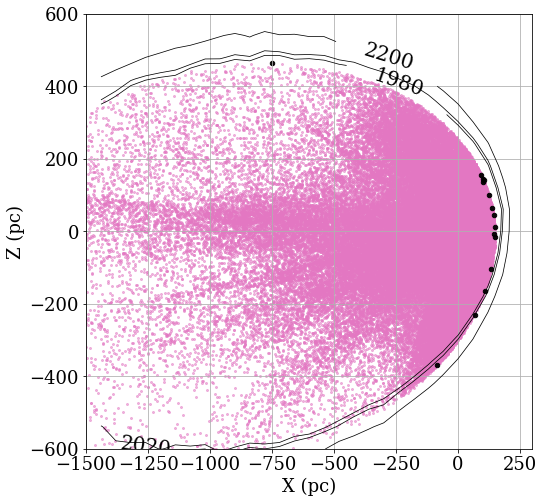

In [27]:
plt.figure(figsize=(8,8))

plt.scatter(Gaia['x'][EYES & y10], Gaia['z'][EYES & y10], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(Gaia['x'][OYES & y10], Gaia['z'][OYES & y10], c='k', s=20, alpha=0.95, rasterized=True)

plt.xlabel('X (pc)')
plt.ylabel('Z (pc)')
cs = plt.contour(xe[1:], ye[1:], H.T, colors='k', linewidths=0.75, levels=[1980, 2020, 2200])
plt.clabel(cs, fontsize=20)

plt.xlim(-1500, 300)
plt.ylim(-600, 600)
plt.grid(True)

Text(0, 0.5, 'Z (pc)')

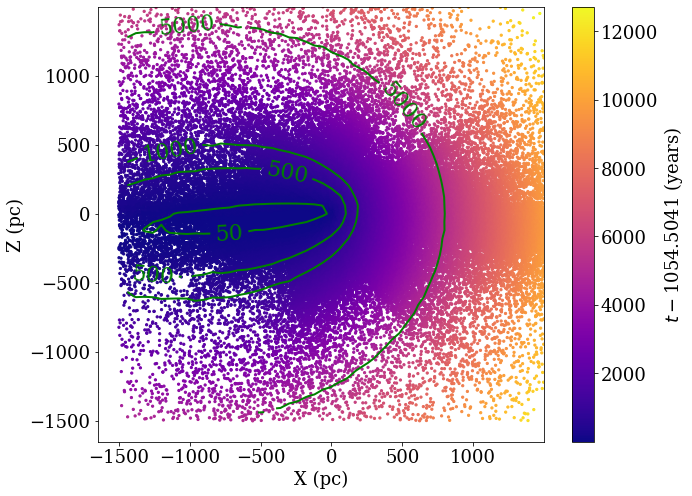

In [28]:
H, xe, ye, bn = binned_statistic_2d(Gaia['x'][y10], Gaia['z'][y10],
                                    values = etime[y10].value, statistic='mean', bins=50)
XX, YY = np.meshgrid(xe, ye)

plt.figure(figsize=(10,8))
plt.scatter(Gaia['x'][y10], Gaia['z'][y10],
            c=(etime[y10].value), cmap=plt.cm.plasma, s=5)
cb = plt.colorbar()
cb.set_label('$t - $'+format(t0.decimalyear, '7.4f') + ' (years)')

cs = plt.contour(xe[1:], ye[1:], H.T, colors='g', linewidths=2, levels=[50,500,1000,5000])
plt.clabel(cs, fontsize=22)


plt.xlabel('X (pc)')
plt.ylabel('Z (pc)')

In [29]:
# Which stars have crossed the ellipsoid since Gaia begain observing?
gstart = Time('2014.569312182902', format='decimalyear') # first Gaia alert
gstart1987 = (gstart-t0).to('year').value # years between first Gaia alert and date SN 1987A observed on Earth

e7 = ((etime.value >= gstart1987) & # since the first alert
      (etime.value < ((t1-t0).to('year').value+0.1)) # up to 0.1 years from now
     ) 
print('Variable stars that have crossed the ellipsoid since Gaia began observing: ' + str(np.ma.sum(e7)))

Variable stars that have crossed the ellipsoid since Gaia began observing: 4868


In [30]:
CE7 = SkyCoord(ra=Gaia['ra'][e7], dec=Gaia['dec'][e7], distance=Gaia['dist'][e7], frame = 'icrs')

(-1100.0, 1100.0)

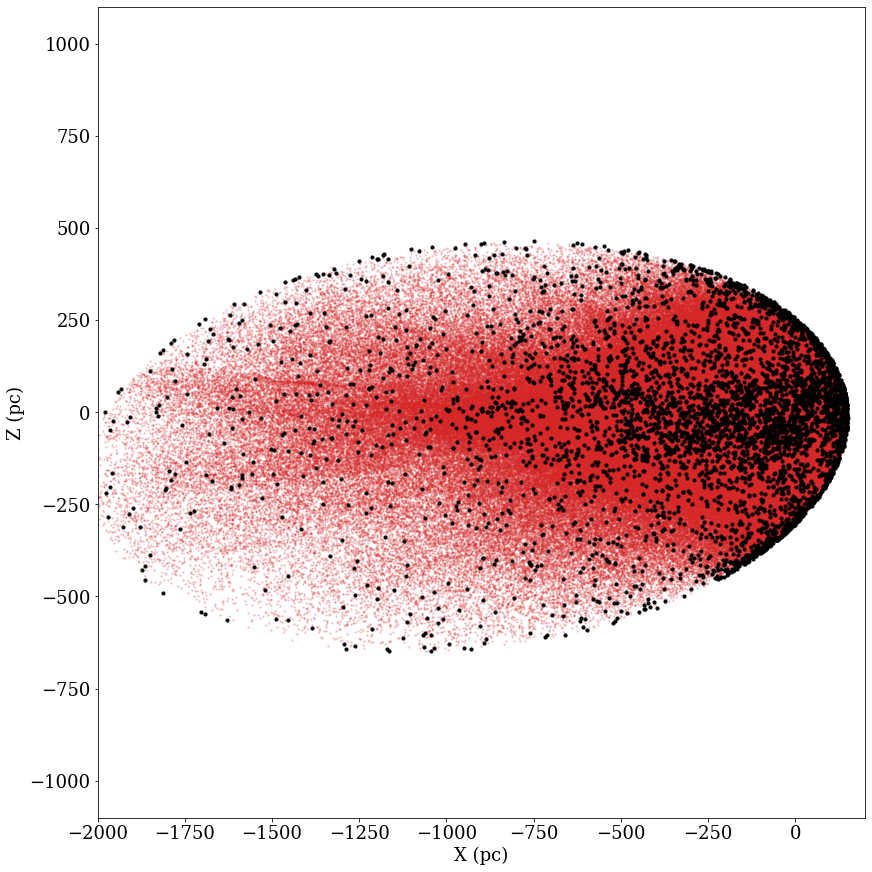

In [31]:
fig = plt.figure(figsize=(12,12), constrained_layout=True)
ax.remove()
ax = fig.add_subplot()


ax.scatter(Gaia['x'][EYES], Gaia['z'][EYES], c='C3', s=2, alpha=0.2, rasterized=True)
ax.scatter(Gaia['x'][e7], Gaia['z'][e7], c='k', s=10, alpha=0.95, rasterized=True)

ax.set_xlabel('X (pc)')
ax.set_ylabel('Z (pc)')
ax.set_xlim(-2000, 200)
ax.set_ylim(-1100, 1100)

Black dots above have crossed the SETI Ellipsoid since Gaia's first alert.

Text(0.5, 0, 'Z (pc)')

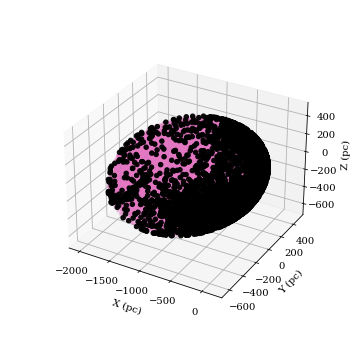

In [32]:
%matplotlib widget

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Gaia['x'][EYES], Gaia['y'][EYES], Gaia['z'][EYES], c='C6', s=4, alpha=0.1, rasterized=True)
ax.scatter(Gaia['x'][e7], Gaia['y'][e7], Gaia['z'][e7], c='k', s=20, alpha=0.95, rasterized=True)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

# Black points are those that have crossed the ellipse since Gaia has been active

In [33]:
hh, be = np.histogram(etime.value, bins = np.arange(100)) # histogram of crossing times (for 100 years after 1987)

print(f'Average of {np.mean(hh):0.1f} variable stars cross the ellipsoid per year from 1987-2087')
print(f'Median of {np.median(hh):0.1f} variable stars cross the ellipsoid per year from 1987-2087')

Average of 614.3 variable stars cross the ellipsoid per year from 1987-2087
Median of 602.0 variable stars cross the ellipsoid per year from 1987-2087


In [34]:
derror = (((Gaia['dist84'] - Gaia['dist']) + (Gaia['dist'] - Gaia['dist16']))/2).to('lyr')
op = (derror < 0.1*u.lyr)

hh1, be1 = np.histogram(etime[op].value, bins = np.arange(100))

print(f'Average of {np.mean(hh1):0.1f} variable stars cross the ellipsoid per year w/ distance error < 0.1 lyr')
print(f'Median of {np.median(hh1):0.1f} variable stars cross the ellipsoid per year w/ distance error < 0.1 lyr')

Average of 9.1 variable stars cross the ellipsoid per year w/ distance error < 0.1 lyr
Median of 8.0 variable stars cross the ellipsoid per year w/ distance error < 0.1 lyr


#### CMD of Variable Stars in Gaia that have crossed the ellipsoid since Gaia began observing

In [35]:
brcol = Gaia['bp'][e7] - Gaia['rp'][e7]
mag = Gaia['g'][e7]
absmag = mag - 5.*np.log10(Gaia['dist'][e7]) + 5.

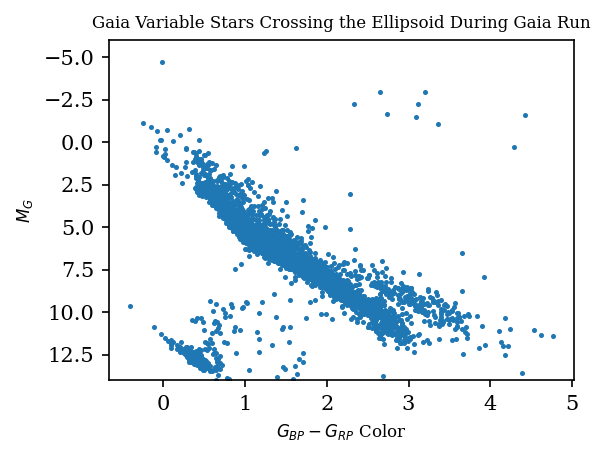

In [36]:
%matplotlib inline
plt.figure(dpi=150,figsize=(4,3))

plt.scatter(brcol.value, absmag.value, s=2)
plt.ylim(14, -6)
plt.title('Gaia Variable Stars Crossing the Ellipsoid During Gaia Run', fontsize=8)
plt.xlabel('$G_{BP} - G_{RP}$ Color', fontsize=8)
plt.ylabel('$M_G$', fontsize=8)

plt.savefig('CMD1_Gaia', transparent=False, facecolor='white')

#### CMD with variable classification

In [37]:
classes = [str(i, 'utf-8') for i in Gaia['class'][e7].value]

class_colors = {'AGN' : 'lightcoral', 
                'DSCT|GDOR|SXPHE' : 'chocolate',
                'WD' : 'black',
                'LPV' : 'greenyellow',
                'ACV|CP|MCP|ROAM|ROAP|SXARI' : 'forestgreen',
                'S' : 'aquamarine',
                'MICROLENSING' : 'darkslategray',
                'CEP' : 'cyan',
                'YSO' : 'darkorange',
                'RS' : 'pink',
                'ACYG' : 'darkred',
                'BCEP' : 'peru',
                'BE|GCAS|SDOR|WR' : 'mediumpurple',
                'SN' : 'violet',
                'SPB' : 'steelblue',
                'ECL' : 'crimson',
                'ELL' : 'blue',
                'SYST' : 'olivedrab',
                'SOLAR_LIKE' : 'deepskyblue',
                'CV' : 'rosybrown',
                'RR' : 'bisque',
                'SDB' : 'sienna',
                'EP' : 'lightgreen',
                'RCB' : 'skyblue'}

class_colors_label = {}
for cl in classes:
    class_colors_label[cl] = class_colors[cl]

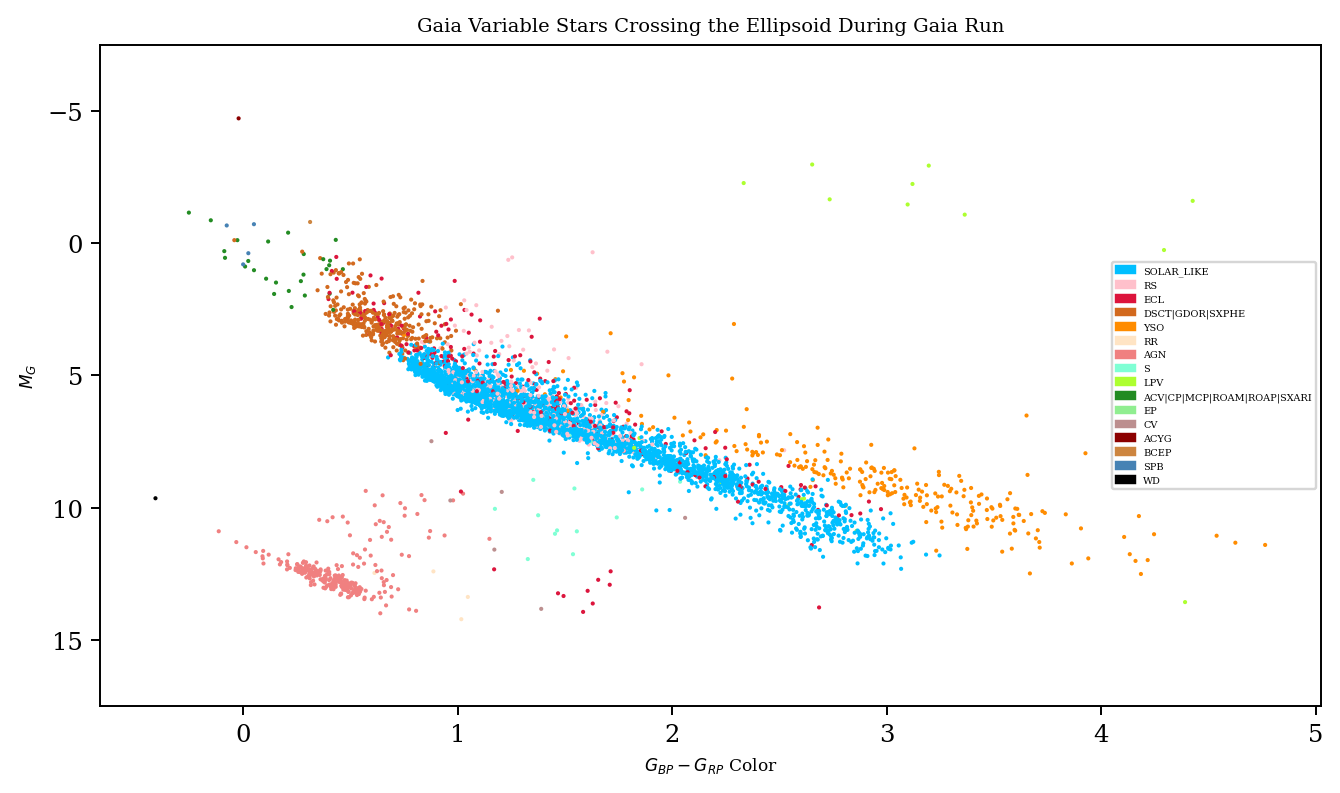

In [38]:
import matplotlib.patches as mpatches

plt.figure(dpi=175,figsize=(9,5))

plt.scatter(brcol.value, absmag.value, s=0.5, c=[ class_colors[i] for i in classes ])
plt.ylim(17.5, -7.5)
plt.title('Gaia Variable Stars Crossing the Ellipsoid During Gaia Run', fontsize=8)
plt.xlabel('$G_{BP} - G_{RP}$ Color', fontsize=7)
plt.ylabel('$M_G$', fontsize=7)

fake_handles = [mpatches.Patch(color=item) for item in class_colors_label.values()]
label = class_colors_label.keys()
plt.legend(fake_handles, label, loc='best', prop={'size': 4})

plt.savefig('CMD2_Gaia', transparent=False, facecolor='white')